## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
* Split data into training and test datasets
    * Normalized datasets
* Building the LSTM model
  * Regressor
  * Sequence
    * Normalization by window of days (steps).
* Testing the model
* Conclusions

### Import Libraries

In [1]:
import os
import io
import math
import random
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [2]:
def download_file(url, filename):
    r = requests.get(url, stream=True)

    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    total_kb_size = math.ceil(total_size//block_size)
    
    wrote = 0 
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=total_kb_size , unit='KB', unit_scale=True):
            wrote = wrote  + len(data)
            f.write(data)

In [3]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    download_file("https://www.coingecko.com/price_charts/export/279/eur.csv", datafile)


In [4]:
data = pd.read_csv(datafile)

#print a random sample
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2015-10-07 00:00:00 UTC
price                          0.542622
market_cap                  4.00145e+07
total_volume                     192774
Name: 60, dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 4 columns):
snapped_at      1069 non-null object
price           1069 non-null float64
market_cap      1068 non-null float64
total_volume    1069 non-null float64
dtypes: float64(3), object(1)
memory usage: 33.5+ KB


Here we can see that every sample is defined by the day in a date format, the current price, the capital market and the total volume of transactions that have been done that day.

At first glance, they are good indicators so all of them will be used as features.

In [6]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [7]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [8]:
features = ['price', 'market_cap', 'total_volume']

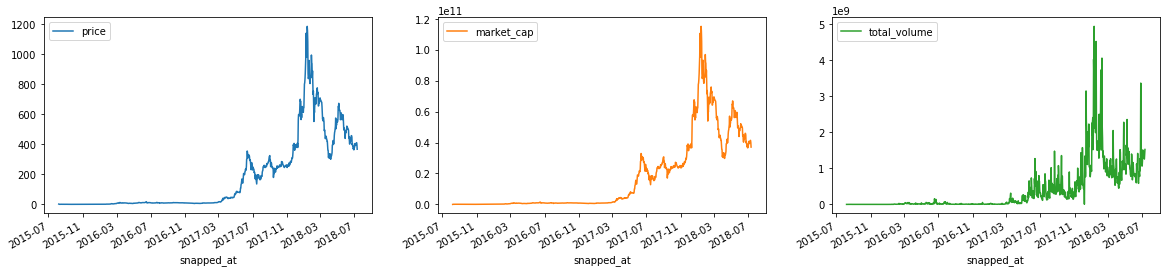

In [9]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

In [10]:
data.iloc[0:10]

,price,market_cap,total_volume
snapped_at,,,
2015-08-07,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1.175306,7.095505e+07,3.250759e+05
2015-08-10,0.624116,3.772033e+07,3.634980e+05
2015-08-11,0.966607,5.844581e+07,1.375588e+06
2015-08-12,1.126292,6.813006e+07,1.858814e+06
2015-08-13,1.636673,9.904778e+07,3.927292e+06
2015-08-14,1.643557,9.951063e+07,3.920484e+06
2015-08-15,1.505036,9.116528e+07,2.269451e+06
2015-08-16,1.329391,8.055977e+07,2.730304e+06


---
### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [11]:
#check
'2015-08-09 00:00:00' in data.index

False

In [12]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

Now, the index is completed but the inexistent samples must be filled out.

#### Find NaN and Fix it

In [13]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [14]:
#check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [15]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

Now we need to include a new feature which will define the closed price for every sample. Ethereum market is always open so we can forget about weekends and use directly the open price of the next sample.

Afterwards the model will use this feature as the target since it's the value we try to predict.

The following script will help us with that.

In [16]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,price,market_cap,total_volume,closed_price
2018-07-07,397.830345,3.999387e+10,1.338706e+09,409.685284
2018-07-08,409.685284,4.119406e+10,1.274561e+09,411.679977
2018-07-09,411.679977,4.140303e+10,1.255668e+09,399.581323
2018-07-10,399.581323,4.019451e+10,1.393201e+09,368.189297
2018-07-11,368.189297,3.704423e+10,1.522987e+09,NaN


In [17]:
#Delete last because we don't know still the closed price 
data = data.drop(data.index[len(data)-1])

----
### Split Data into Training and Test Datasets

In [18]:
#X_train, X_test, y_train, y_test = train_test_split(data[features], 
#                                                    data.closed_price, 
#                                                    test_size=0.20,
#                                                    shuffle=False,
#                                                    random_state=42)

#80% for training
split = round(len(data)*0.9)
data_train, data_test = data[:split].copy(), data[split:].copy()

In [19]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 962
Size data_test: 107


### Normalized Datasets

Take care of this because we __don't know if the future values are in the range__. For this reason we'll __fit the scaler using only the training data__ and not the testing data.

In [20]:
#Scale the data
scaler = MinMaxScaler()

data_train_norm, data_test_norm = data_train.copy(), data_test.copy()

data_train_norm[data.columns] = scaler.fit_transform(data_train[data.columns])
data_test_norm[data.columns] = scaler.transform(data_test[data.columns])

data_test_norm.describe()

,price,market_cap,total_volume,closed_price
count,107.000000,107.000000,107.000000,107.000000
mean,0.390011,0.400464,0.218063,0.389601
std,0.080871,0.082933,0.088177,0.081167
min,0.253360,0.258040,0.090536,0.253360
25%,0.333627,0.342954,0.160941,0.332778
50%,0.378366,0.390610,0.197320,0.378366
75%,0.451000,0.461024,0.257057,0.451000
max,0.567774,0.581333,0.681403,0.567774


---
## Building the Model

### Check Tensorflow and GPU

In [21]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


### Regressor model

* 1 step and 3 features

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

X_train = data_train_norm[features].values.reshape((data_train_norm.shape[0], 1, 3))
y_train = data_train_norm.closed_price.values

X_test = data_test_norm[features].values.reshape((data_test_norm.shape[0], 1, 3))
y_test = data_test_norm.closed_price.values


Using TensorFlow backend.


In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(962, 1, 3)
(962,)
(107, 1, 3)
(107,)


In [24]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

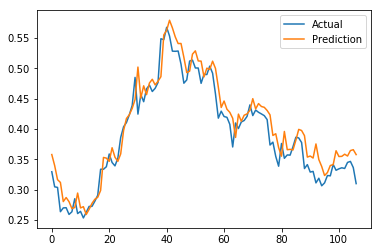

In [25]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [26]:
r2_score(y_test, pred)

0.90217932457135985

### Sequence model

* 7 steps and 3 features

In [27]:
'''
Helper function to transform the dataset to
shapes defined by 7 steps and 3 features
'''
def prepare_sequence(data, sequence_size=7):
    sequence = []
    buckets = data.shape[0]//sequence_size
    init_sample = data.shape[0] - buckets*sequence_size
    samples = 0
    for i in range(init_sample, data.shape[0] - sequence_size + 1):
        sequence.append(data[i:i+7])
        samples += 1
    return np.concatenate(sequence).reshape((samples, sequence_size, data.shape[1]))

prepare_sequence(data[features]).shape

(1058, 7, 3)

In [28]:
#getting (samples, steps, features)
X_train = prepare_sequence(data_train_norm[features])
X_test = prepare_sequence(data_test_norm[features])

y_train = data_train_norm.iloc[-len(X_train):].closed_price.values
y_test = data_test_norm.iloc[-len(X_test):].closed_price.values

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(953, 7, 3)
(953,)
(99, 7, 3)
(99,)


In [30]:
model = Sequential()
model.add(LSTM(32, input_shape=(7, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

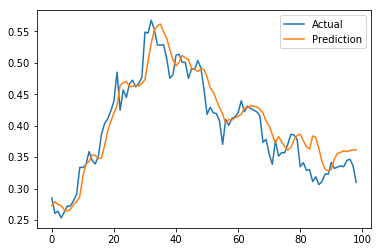

In [31]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [32]:
r2_score(y_test, pred)

0.87255359733053095

### ⇩ __NORMALIZE A WINDOW OF STEPS (SEQUENCES) ⇩

The neural network is not able to get good predictions for that data that has not seen before. For that reason we can find day that are not well fitted. This problem is related to the __'out-of-scale'__ data inputs.

#### Custom: by the rate of change ####

Thinking that the batch size is a window of days that defines how the neural network learns, one idea is to normalize the window by the last sample. On this way we'll be able to keep almost all data in the same scale.

In [33]:
def print_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    print("mean:{:.3f} std:{:.3f}".format(mean, std))

In [47]:
def window_normalization(data, window_size):
    y = np.empty_like(data, dtype='float64')
    normalizer = list()
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data))
        y[i:j] = data[i:j]/np.abs(data[j-1])
        normalizer.append(np.abs(data[j-1]))
        #print_mean_std(y[i:j])
        
    return y, normalizer

def window_denormalization(norm_data, normalizer, window_size):
    y = np.empty_like(norm_data, dtype='float64')
    idx = 0
    for i in range(0,len(norm_data), window_size):
        j = min(i+window_size, len(norm_data))
        y[i:j] = norm_data[i:j]*normalizer[idx]
        idx += 1
        
    return y

In [48]:
#testing the function
a = np.array([[1, 1, 1], [2, 2, 2], [2, 2, 2], [8, 8, 8]])
expected_result = np.array([[0.5, 0.5, 0.5], [1, 1, 1], [0.25, 0.25, 0.25], [1, 1, 1]])
norm_a, normalizer = window_normalization(a, 2)

assert ( np.array_equal(norm_a, expected_result) )
assert ( np.array_equal(a, window_denormalization(norm_a, normalizer, 2)) )

#### Standardization
There is another kind of normalization (specially robust for new values outside of the expected values.

_*__Note:__ this method assumes the distribution of data fits to Gaussian distribution._

In [50]:
from sklearn.preprocessing import StandardScaler

#global
scaler = StandardScaler()

def window_normalization_std(data):
    return scaler.fit_transform(data)

def window_denormalization_std(norm_data):
    return scaler.inverse_transform(norm_data)

In [49]:
#Showing the last sample
data.index[-1].strftime("%d-%m-%Y")

'10-07-2018'

In [38]:
window_size=32

X_train = data_train[features].values
y_train = data_train.closed_price.values

X_train_norm, _ = window_normalization(X_train, window_size)
y_train_norm, y_normalizer = window_normalization(y_train, window_size)

#getting (samples, steps, features)
X_train_norm = prepare_sequence(X_train_norm)
y_train_norm = y_train_norm[-len(X_train_norm):]

mean:1.566 std:1.539
mean:1.352 std:0.592
mean:0.884 std:0.577
mean:0.769 std:0.267
mean:0.725 std:0.328
mean:0.563 std:0.432
mean:0.720 std:0.328
mean:1.070 std:0.325
mean:0.604 std:0.230
mean:0.885 std:0.414
mean:0.670 std:0.324
mean:2.814 std:4.415
mean:1.275 std:1.012
mean:0.936 std:0.262
mean:1.284 std:0.602
mean:1.078 std:0.742
mean:1.042 std:0.526
mean:0.758 std:0.536
mean:0.958 std:0.596
mean:0.734 std:0.451
mean:0.961 std:0.800
mean:1.371 std:0.473
mean:0.865 std:0.405
mean:1.102 std:0.312
mean:0.946 std:0.481
mean:0.903 std:0.251
mean:0.725 std:0.373
mean:0.901 std:0.316
mean:1.207 std:0.418
mean:1.311 std:0.270
mean:1.082 std:0.151
mean:1.049 std:0.173
mean:1.293 std:0.255
mean:0.941 std:0.281
mean:0.956 std:0.064
mean:0.823 std:0.075
mean:0.521 std:0.250
mean:0.805 std:0.298
mean:1.184 std:0.156
mean:0.689 std:0.140
mean:1.109 std:0.168
mean:0.934 std:0.100
mean:1.015 std:0.093
mean:0.949 std:0.065
mean:1.060 std:0.045
mean:1.215 std:0.073
mean:0.977 std:0.054
mean:0.960 st

In [39]:
model = Sequential()
model.add(LSTM(32, input_shape=(7,3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_norm, y_train_norm, epochs=50, batch_size=window_size, verbose=0)

#### With normalized data

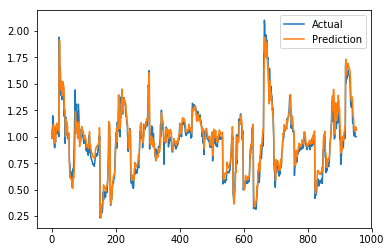

In [40]:
pred = model.predict(X_train_norm)
plt.plot(y_train_norm, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [41]:
r2_score(y_train_norm, pred)

0.9178854014261586

#### With data in actual scale

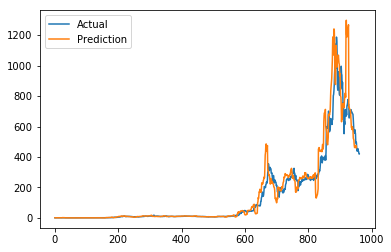

In [42]:
plt.plot(y_train, label='Actual')
plt.plot(window_denormalization(pred, y_normalizer, window_size), label='Prediction')
plt.legend()

---
## Testing the Model

Seeing the last results our best chance of accurate predictions (__at a glance__) is to use:

* LSTM sequence by 7 steps and 3 features
* Window normalization

mean:0.645 std:0.232
mean:1.274 std:0.275
mean:1.152 std:0.335
mean:0.974 std:0.070
mean:0.721 std:0.145
mean:1.304 std:0.124
mean:1.208 std:0.129
mean:1.074 std:0.033


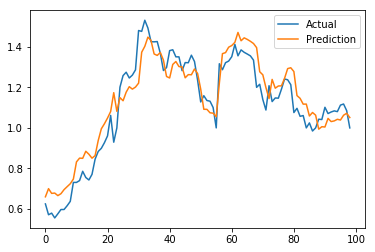

In [43]:
X_test = data_test[features].values
y_test = data_test.closed_price.values

X_test_norm, _ = window_normalization(X_test, window_size)
y_test_norm, y_normalizer = window_normalization(y_test, window_size)

#getting (samples, steps, features)
X_test_norm = prepare_sequence(X_test_norm)
y_test_norm = y_test_norm[-len(X_test_norm):]

pred = model.predict(X_test_norm)
plt.plot(y_test_norm, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [44]:
r2_score(y_test_norm, pred)

0.87885115695412519

#### Return to original scale

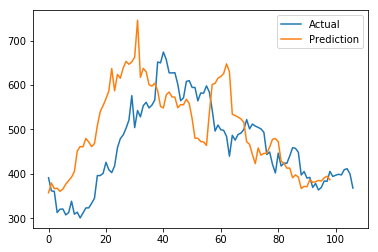

In [45]:
plt.plot(y_test, label='Actual')
plt.plot(window_denormalization(pred, y_normalizer, window_size), label='Prediction')
plt.legend()

## Conclusions

It seems the most accurate is the sequence model using a normalization by window size. Also it's truth the prediction value goes a few days ahead of the actual value.


-----

__Log:__

1. ~~Added new method 'print_mean_std' to detect the stability of the data within the window size.~~
    
2. It has been need to add a denormalization function to recover the real values after predictions. Probably it's not well defined and the algorithm should be re-checked (multiply by normalized number??)
    
3. ~~Testing doesn't have to be normalized.~~

4. Next step, try to __recover original values__ in predictions.
5. Normalization 2.
6. ~~Define a good metric.~~ R2 score.